<img src=https://api-manager.universia.net/coreplatform-document-management/api/document-management/public/6ra7ymjkfi64845 width="300" align="left">
<br />

# Aprendizaje automático I
#### <font color=green>*Máster en Informática Industrial y Robótica*</font>

Daniel Vidal Soroa  
Juan Diego Peña 

## Clasificación de mangos en tres clases según su presencia para la exportación, comercio local o procesamiento industrial

#### Importación de las librerías:

In [2]:
import os
import time
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from datetime import datetime
from keras.models import Sequential
from keras.applications import vgg16, mobilenet, resnet, xception, inception_v3
from keras.layers import Flatten, Dense, BatchNormalization, Dropout
from skimage.io import imread
from skimage.transform import resize
from sklearn.model_selection import train_test_split
from sklearn.metrics import ConfusionMatrixDisplay,confusion_matrix, accuracy_score
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import img_to_array
from skimage.color import rgb2hsv, hsv2rgb
from skimage.feature import hog
from sklearn.cluster import KMeans
from scipy.cluster.hierarchy import ward, fcluster, dendrogram, linkage
from random import seed
from random import randint
from keras import layers
from tqdm import tqdm
import shutil

IMG_SIZE = 120

# Función para añadir datos a una tebla de excel
def append_data_to_excel(excel_name, df):
    with pd.ExcelWriter(excel_name,
        mode="a",
        engine="openpyxl",
        if_sheet_exists="overlay") as writer:
        start_row = 0
        header = True
        if os.path.exists(excel_name):
            df_source = pd.read_excel(excel_name, engine="openpyxl").iloc[:,1:]
        if df_source is not None:
            n, m = df_source.shape
            header = False if n > 0 else True
            start_row = n + 1 if n > 0 else n
        
        df.to_excel(writer, sheet_name="Sheet1",startcol=0, startrow = start_row, header=header)

def get_base_model(name):
    if name == 'vgg':
        return vgg16.VGG16(include_top=False, weights='imagenet', input_shape=(IMG_SIZE,IMG_SIZE,3))
    elif name == 'inception':
        return inception_v3.InceptionV3(include_top=False, weights='imagenet', input_shape=(IMG_SIZE,IMG_SIZE,3))
    elif name == 'xception':
        return xception.Xception(include_top=False, weights='imagenet', input_shape=(IMG_SIZE,IMG_SIZE,3))
    else: return resnet.ResNet50(include_top=False, weights='imagenet', input_shape=(IMG_SIZE,IMG_SIZE,3))

def preprocess_data(name, x):
    if name == 'vgg':
        return vgg16.preprocess_input(x)
    elif name == 'inception':
        return inception_v3.preprocess_input(x)
    elif name == 'xception':
        return xception.preprocess_input(x)
    else: return resnet.preprocess_input(x)


In [41]:
def image_feature(names, path):
    model = get_base_model(model_name)
    features = []
    img_name = []
    for name in tqdm(names):
        fname = path +'/'+ name
        img = image.load_img(fname,target_size=(IMG_SIZE, IMG_SIZE))
        x = img_to_array(img)
        x = np.expand_dims(x,axis=0)
        feat = model.predict(x)
        feat = feat.flatten()
        features.append(feat)
        img_name.append(name)
    return features,img_name

def hog_feature(names, path):
    orient = 8
    ppc = 8
    cpb = 3
    features = []
    img_name = []
    for name in tqdm(names):
        fname = path +'/'+ name
        img = image.load_img(fname,target_size=(IMG_SIZE, IMG_SIZE))
        x = img_to_array(img)
        fd = hog(x, orientations=orient, pixels_per_cell=(ppc, ppc),
                    cells_per_block=(cpb, cpb), channel_axis=2)
        feat = fd.flatten()
        features.append(feat)
        img_name.append(name)
    return features,img_name

def rgb_feature(names, path):
    features = []
    img_name = []
    for name in tqdm(names):
        fname=path +'/'+ name
        img=image.load_img(fname,target_size=(IMG_SIZE, IMG_SIZE))
        x = img_to_array(img)
        x = np.expand_dims(x,axis=0)
        feat = x.flatten()
        features.append(feat)
        img_name.append(name)
    return features,img_name

#### Lectura de los datos:

83697664/83683744 [==============================] - 3s 0us/step


100%|██████████| 600/600 [00:57<00:00, 10.39it/s]


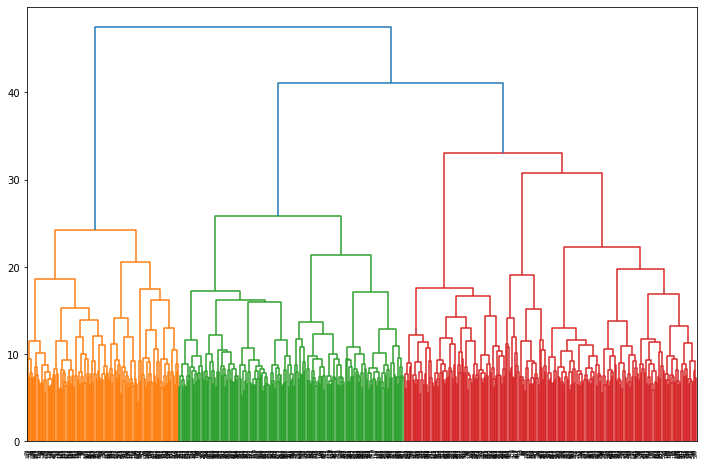

0.3


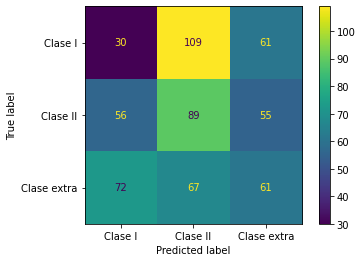

In [3]:
# Function to Extract features from the images
model_name = 'hog'

# Leer los nombres de las imágenes para importarlas
input_cluster_path = "./Dataset/Grading_dataset/Cluster"
_names = os.listdir(input_cluster_path)

tic = time.perf_counter()
if model_name == 'rgb':
    img_features,img_name = rgb_feature(_names, input_cluster_path)
elif model_name == 'hog':
    img_features,img_name = hog_feature(_names, input_cluster_path)
else:
    img_features,img_name = image_feature(_names, input_cluster_path)

cluster_method = "decision_tree"
k = 3
#Creating Clusters
if cluster_method == "kmeans":
    clusters = KMeans(k, random_state = 40)
    clusters.fit(img_features)
    toc = time.perf_counter()
    eval_time = round((toc-tic), 2)

    image_cluster = pd.DataFrame(img_name,columns=['image'])
    image_cluster["clusterid"] = clusters.labels_
    image_cluster 
    y = clusters.labels_
    t = np.concatenate((np.ones(200), 2 * np.ones(200), np.zeros(200)), axis = 0)
elif cluster_method == "decision_tree":
    Z = linkage(img_features, 'ward')
    fig = plt.figure(figsize=(12, 8))
    dn = dendrogram(Z)
    plt.show()
    labels = fcluster(Z, t = k, criterion='maxclust')
    toc = time.perf_counter()
    y = labels
    t = np.concatenate((np.ones(200), 2 * np.ones(200), 3 * np.ones(200)), axis = 0)


Clases=['Clase I','Clase II','Clase extra']
accuracy = round(accuracy_score(t,y),2)
print(round(accuracy_score(t,y),2))
cm = confusion_matrix(t, y)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=Clases)
disp.plot()


#### Se muestra la matriz de confusión para conocer el desempeño del algoritmo

In [59]:
eval_time = round((toc-tic), 2)
test_data = {'base model':model_name,
        'algorithm': cluster_method,
        'accuracy': accuracy,
        'eval time': eval_time
        }

now = datetime.now() # current date and time       
time_ = {now.strftime("%d/%m/%Y %H:%M:%S")}
df = pd.DataFrame(test_data, index = time_)
excel_name = "./informe/tables/Clustering.xlsx"
append_data_to_excel(excel_name, df)

#### Se crea una carpeta para guardar cada clase

In [18]:
# Made folder to seperate images
clusterI_path = "./Dataset/Grading_dataset/cluster I"
clusterII_path = "./Dataset/Grading_dataset/cluster II"
clusterIII_path = "./Dataset/Grading_dataset/cluster III"
# Images will be seperated according to cluster they belong
for i in range(len(image_cluster)):
    if image_cluster['clusterid'][i]==0:
        shutil.copy(os.path.join(input_cluster_path, image_cluster['image'][i]), clusterI_path)
    elif image_cluster['clusterid'][i]==1:
        shutil.copy(os.path.join(input_cluster_path, image_cluster['image'][i]), clusterII_path)
    else:
        shutil.copy(os.path.join(input_cluster_path, image_cluster['image'][i]), clusterIII_path)